In [40]:
import spacy
import torch
import torch.nn as nn
import torchtext
from torchtext import datasets
import torch.optim as optim

import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [41]:
tweets = pd.read_csv("datasets/tweets/tweets.csv", on_bad_lines="skip")
tweets = tweets.head(50000)
tweets.head()

,ItemID,Sentiment,SentimentSource,SentimentText
0,1,neg,Sentiment140,is so sad for my APL frie...
1,2,neg,Sentiment140,I missed the New Moon trail...
2,3,pos,Sentiment140,omg its already 7:30 :O
3,4,neg,Sentiment140,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,5,neg,Sentiment140,i think mi bf is cheating on me!!! ...


In [42]:
tweets = tweets.drop(columns=["ItemID", "SentimentSource"], axis=1)
tweets.head()

,Sentiment,SentimentText
0,neg,is so sad for my APL frie...
1,neg,I missed the New Moon trail...
2,pos,omg its already 7:30 :O
3,neg,.. Omgaga. Im sooo im gunna CRy. I've been at...
4,neg,i think mi bf is cheating on me!!! ...


In [43]:
tweets.shape


(50000, 2)

In [44]:
tweets["Sentiment"].unique()

array(['neg', 'pos'], dtype=object)

In [45]:
tweets.Sentiment.value_counts()


pos    26921
neg    23079
Name: Sentiment, dtype: int64

[Text(0.5, 0, 'Labels')]

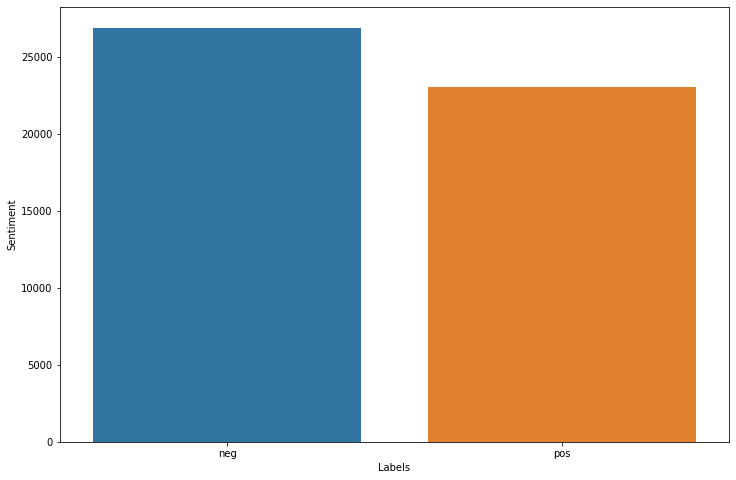

In [46]:
fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x=tweets.Sentiment.unique(), y=tweets.Sentiment.value_counts())
ax.set(xlabel="Labels")

In [47]:
train, test = train_test_split(tweets, test_size=0.2, random_state=42)


In [48]:
train.reset_index(drop=True), test.reset_index(drop=True)

(      Sentiment                                      SentimentText
 0           pos  @amyrenea omg so am I lol I fell asleep when i...
 1           neg               @Adrienne_Bailon I want a shout out 
 2           neg  @Anonymousboy03 Plans for school stuff &amp; a...
 3           neg  ... has hit a writer's block .. am loosing my ...
 4           neg  ... trying to find people I know! I`m bored, i...
 ...         ...                                                ...
 39995       pos   #robotpickuplines are so funny. check them out. 
 39996       pos  @annyo84 awh thankss.  yeah, i understand what...
 39997       pos  @AmbiguityX ohh you're in twin cities?  i luv ...
 39998       neg   Dinara lost again in Roland Garros. Why the S...
 39999       pos  *yawn* fucking time zones shit. I'm really sic...
 
 [40000 rows x 2 columns],
      Sentiment                                      SentimentText
 0          pos  @aimeesays aww i hope it does fly by because J...
 1          neg  #don

In [49]:
train.to_csv("datasets/tweets/train_tweets.csv", index=False)
test.to_csv("datasets/tweets/test_tweets.csv", index=False)

In [50]:
def tweet_clean(text):
    text = re.sub(r"[^A-Za-z0-9]+", " ", text)
    text = re.sub(r"https?:/\/\S+", " ", text)

    return text.strip()

In [51]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "ner"])


def tokenizer(s):
    return [w.text.lower() for w in nlp(tweet_clean(s))]

In [52]:
TEXT = torchtext.data.Field(tokenize=tokenizer)
LABEL = torchtext.data.LabelField(dtype=torch.float)

In [53]:
datafields = [("Sentiment", LABEL), ("SentimentText", TEXT)]

In [54]:
trn, tst = torchtext.data.TabularDataset.splits(
    path="datasets/tweets/",
    train="train_tweets.csv",
    test="test_tweets.csv",
    format="csv",
    skip_header=True,
    fields=datafields,
)

C:\Users\natha\AppData\Roaming\Python\Python310\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [55]:
print(f"Number of training exampes: {len(trn)}")
print(f"Number of testing examples: {len(tst)}")


Number of training exampes: 40000
Number of testing examples: 10000


In [56]:
vars(trn.examples[0])

{'Sentiment': 'pos',
 'SentimentText': ['amyrenea',
  'omg',
  'so',
  'am',
  'i',
  'lol',
  'i',
  'fell',
  'asleep',
  'when',
  'it',
  'was',
  'on',
  'last',
  'night',
  'so',
  'now',
  'i',
  'get',
  'to',
  'finish',
  'it']}

In [57]:
TEXT.build_vocab(
    trn, max_size=25000, vectors="glove.6B.100d", unk_init=torch.Tensor.normal_
)
LABEL.build_vocab(trn)


In [58]:
print(TEXT.vocab.freqs.most_common(50))


[('i', 25644), ('the', 12219), ('to', 12111), ('you', 10723), ('a', 9197), ('it', 8440), ('and', 6889), ('my', 6208), ('quot', 5582), ('s', 5565), ('that', 5306), ('is', 5203), ('for', 4971), ('in', 4852), ('t', 4844), ('m', 4683), ('me', 4588), ('of', 4331), ('on', 3918), ('have', 3752), ('so', 3612), ('but', 3506), ('be', 2932), ('not', 2887), ('was', 2775), ('just', 2724), ('can', 2523), ('do', 2418), ('are', 2351), ('your', 2320), ('with', 2269), ('good', 2203), ('like', 2173), ('at', 2131), ('no', 2119), ('this', 2094), ('all', 2069), ('up', 2066), ('now', 2063), ('get', 2044), ('we', 1988), ('u', 1890), ('love', 1885), ('lol', 1864), ('too', 1826), ('what', 1760), ('out', 1742), ('know', 1664), ('nt', 1608), ('amp', 1539)]


In [59]:
print(TEXT.vocab.itos[:10])


['<unk>', '<pad>', 'i', 'the', 'to', 'you', 'a', 'it', 'and', 'my']


In [60]:
print(LABEL.vocab.stoi)


defaultdict(None, {'pos': 0, 'neg': 1})


In [61]:
train_iterator, test_iterator = torchtext.data.BucketIterator.splits(
    (trn, tst),
    batch_size=64,
    sort_key=lambda x: len(x.SentimentText),
    sort_within_batch=False,
)

In [62]:
class RNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        hidden_dim,
        output_dim,
        n_layers,
        bidirectional,
        dropout,
    ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.GRU(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, hidden = self.rnn(embedded)
        hidden = self.dropout(torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1))
        return self.fc(hidden.squeeze(0))


In [63]:
input_dim = len(TEXT.vocab)
embedding_dim = 100
hidden_dim = 20
output_dim = 1
n_layers = 2
bidirectional = True
dropout = 0.5


In [64]:
model = RNN(
    input_dim, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout
)

In [65]:
model


RNN(
  (embedding): Embedding(25002, 100)
  (rnn): GRU(100, 20, num_layers=2, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=40, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [66]:
pretrained_embeddings = TEXT.vocab.vectors
print(pretrained_embeddings.shape)


torch.Size([25002, 100])


In [67]:
model.embedding.weight.data.copy_(pretrained_embeddings)


tensor([[-0.5646,  0.7396, -0.8372,  ...,  0.8436,  1.1336, -0.7308],
        [-0.5556,  0.2236, -2.0112,  ...,  1.1270,  0.7417, -0.1556],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5211,  0.0658,  0.0974,  ...,  0.3269,  0.4554,  1.2100],
        [-0.0722,  0.6892,  0.0027,  ...,  0.9599, -0.2160,  1.6911],
        [ 1.6255, -0.6749,  1.5421,  ...,  0.5531,  2.3623, -1.0693]])

In [68]:
unk_idx = TEXT.vocab.stoi[TEXT.unk_token]
pad_idx = TEXT.vocab.stoi[TEXT.pad_token]

model.embedding.weight.data[unk_idx] = torch.zeros(embedding_dim)
model.embedding.weight.data[pad_idx] = torch.zeros(embedding_dim)

print(model.embedding.weight.data)


tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0465,  0.6197,  0.5665,  ..., -0.3762, -0.0325,  0.8062],
        ...,
        [-0.5211,  0.0658,  0.0974,  ...,  0.3269,  0.4554,  1.2100],
        [-0.0722,  0.6892,  0.0027,  ...,  0.9599, -0.2160,  1.6911],
        [ 1.6255, -0.6749,  1.5421,  ...,  0.5531,  2.3623, -1.0693]])


In [69]:
optimizer = optim.Adam(model.parameters())
criterion = nn.BCEWithLogitsLoss()


In [70]:
def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in iterator:
        optimizer.zero_grad()
        predictions = model(batch.SentimentText).squeeze(1)
        loss = criterion(predictions, batch.Sentiment)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float()
        acc = correct.sum() / len(correct)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [71]:
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    print(
        f"| Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% |"
    )

| Epoch: 01 | Train Loss: 0.635 | Train Acc: 62.95% |
| Epoch: 02 | Train Loss: 0.541 | Train Acc: 73.32% |
| Epoch: 03 | Train Loss: 0.496 | Train Acc: 76.01% |
| Epoch: 04 | Train Loss: 0.472 | Train Acc: 77.54% |
| Epoch: 05 | Train Loss: 0.447 | Train Acc: 79.39% |
| Epoch: 06 | Train Loss: 0.428 | Train Acc: 80.47% |
| Epoch: 07 | Train Loss: 0.409 | Train Acc: 81.42% |
| Epoch: 08 | Train Loss: 0.392 | Train Acc: 82.57% |
| Epoch: 09 | Train Loss: 0.380 | Train Acc: 83.09% |
| Epoch: 10 | Train Loss: 0.368 | Train Acc: 83.98% |


In [72]:
epoch_loss = 0
epoch_acc = 0

model.eval()

with torch.no_grad():
    for batch in test_iterator:
        predictions = model(batch.SentimentText).squeeze(1)
        loss = criterion(predictions, batch.Sentiment)
        rounded_preds = torch.round(torch.sigmoid(predictions))
        correct = (rounded_preds == batch.Sentiment).float()
        acc = correct.sum() / len(correct)
        epoch_loss += loss.item()
        epoch_acc += acc.item()

test_loss = epoch_loss / len(test_iterator)
test_acc = epoch_acc / len(test_iterator)

print(f"Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%")

Test Loss: 0.491 | Test Acc: 77.40%


In [80]:
#sentence = "I hate that show"
sentence = "That move was really nice"

In [81]:
tokenized = [tok.text for tok in nlp.tokenizer(sentence)]

In [82]:
indexed = [TEXT.vocab.stoi[t] for t in tokenized]

In [83]:
tensor = torch.LongTensor(indexed)

In [84]:
tensor = tensor.unsqueeze(1)

In [85]:
prediction = torch.sigmoid(model(tensor))

In [86]:
prediction.item()

0.319663941860199